Inpainting using Sparse Regularization
======================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores the use of
sparse energies to regularize the image inpainting problem.

In [1]:
library(pracma)
# library(OpenImageR)
library(imager)

# Importing the libraries
for (f in list.files(path="nt_toolbox/toolbox_general/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_general/", f, sep=""))
}
for (f in list.files(path="nt_toolbox/toolbox_signal/", pattern="*.R")) {
    source(paste("nt_toolbox/toolbox_signal/", f, sep=""))
}

Warning message:
"package 'imager' was built under R version 3.3.2"Loading required package: plyr
Loading required package: magrittr

Attaching package: 'magrittr'

The following objects are masked from 'package:pracma':

    and, mod, or


Attaching package: 'imager'

The following object is masked from 'package:magrittr':

    add

The following object is masked from 'package:plyr':

    liply

The following objects are masked from 'package:stats':

    convolve, spectrum

The following object is masked from 'package:graphics':

    frame

The following object is masked from 'package:base':

    save.image

Warning message:
"package 'tuneR' was built under R version 3.3.2"
Attaching package: 'tuneR'

The following objects are masked from 'package:imager':

    channel, play

Warning message:
"package 'akima' was built under R version 3.3.2"
Attaching package: 'akima'

The following object is masked from 'package:imager':

    interp



Here we consider inpainting of damaged observation without noise.

Sparse Regularization
---------------------
This tour consider measurements $y=\Phi f_0 + w$
where $\Phi$ is a masking operator
and $w$ is an additive noise.


This tour is focused on using sparsity to recover an image from the
measurements $y$. It considers a synthesis-based regularization, that
compute a sparse set of coefficients $ (a_m^{\star})_m $
in a frame $\Psi = (\psi_m)_m$ that solves
$$a^{\star} \in \text{argmin}_a \: \frac{1}{2}\|y-\Phi \Psi a\|^2 + \lambda J(a)$$


where $\lambda$ should be adapted to the noise level $\|w\|$.
Since in this tour we consider damaged observation without noise, i.e.
$w=0$, we use either a very small value of $\lambda$, or we decay its
value through the iterations of the recovery process.


Here we use the notation
$$\Psi a = \sum_m a_m \psi_m$$
to indicate the reconstruction operator, and $J(a)$ is the $\ell^1$
sparsity prior
$$J(a)=\sum_m \|a_m\|.$$


Missing Pixels and Inpainting
-----------------------------
Inpainting corresponds to filling holes in images.
This corresponds to a linear ill posed inverse problem.


You might want to do first the numerical tour _Variational image inpaiting_
that use Sobolev and TV priors to performs the inpainting.


First we load the image to be inpainted.

In [2]:
n = 128
f0 = load_image("nt_toolbox/data/lena.png")
f0 = t(f0[,])
f0 = rescale(f0[(256 - n / 2 + 1):(256 + n / 2), (256 - n / 2 + 1) : (256 + n / 2)])

Display it.

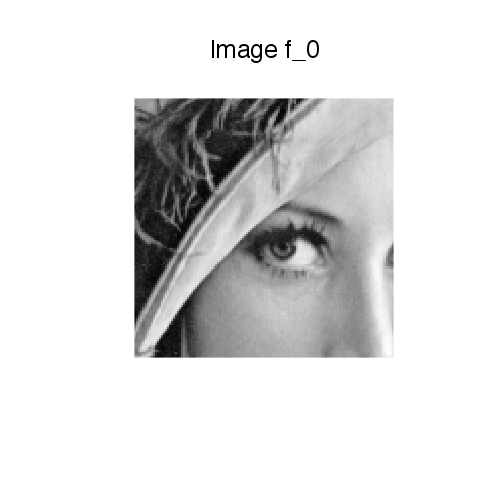

In [3]:
options(repr.plot.width=4, repr.plot.height=4)
imageplot(f0, 'Image f_0')

Amount of removed pixels.

In [4]:
rho = 0.7

Then we construct a mask $\Omega$ made of random pixel locations.

In [5]:
set.seed(1)
Omega = c(matrix(0, n, n))
sel = sample(n**2)
Omega[sel[1:as.integer(rho * n**2)]] = 1
Omega = matrix(Omega, n, n)

The damaging operator put to zeros the pixel locations $x$ for which $\Omega(x)=1$

In [6]:
Phi = function(f, Omega){f * (1 - Omega)}

The damaged observations reads $y = \Phi f_0$.

In [7]:
y = Phi(f0, Omega)

Display the observations.

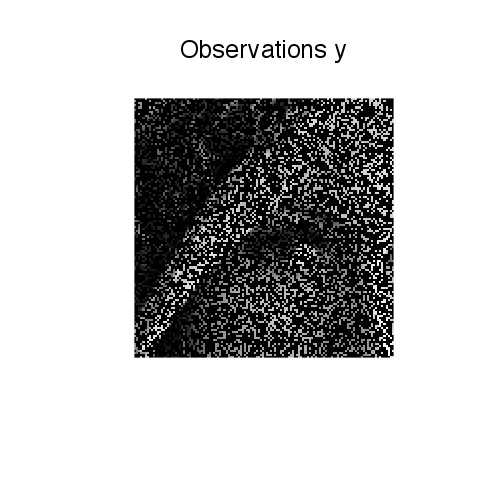

In [8]:
imageplot(y, 'Observations y')

Soft Thresholding in a Basis
----------------------------
The soft thresholding operator is at the heart of $\ell^1$ minimization
schemes. It can be applied to coefficients $a$, or to an image $f$
in an ortho-basis.


The soft thresholding is a 1-D functional that shrinks the value of
coefficients.
$$ s_T(u)=\max(0,1-T/|u|)u $$


Define a shortcut for this soft thresholding 1-D functional.

In [9]:
SoftThresh = function(x, T)
{
    if (!is.null(dim(x)))
    {
        return(x * pmax(1 - T / abs(x), 1e-10 * array(1, dim=dim(x)), array(0, dim=dim(x))))
    }
    else
    {
        return(x * pmax(1 - T / abs(x), 1e-10 * rep(1, length(x)), rep(0, length(x))))
    }
}

Display a curve of the 1D soft thresholding.

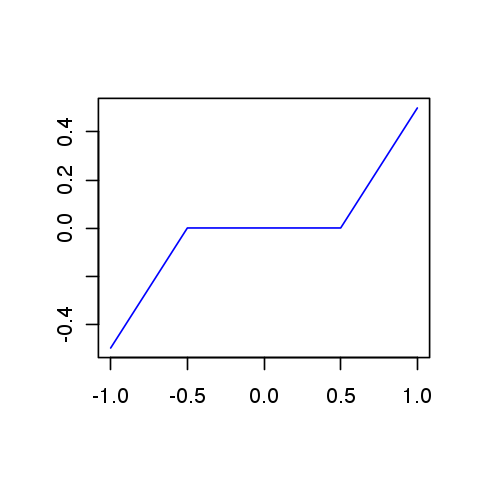

In [10]:
x = seq(-1, 1, length=1000)

plot(x, SoftThresh(x, .5), col=4, type="l", ylab="", xlab="")

Note that the function SoftThresh can also be applied to vector which defines an
operator on coefficients:
$$ S_T(a) = ( s_T(a_m) )_m. $$


In the next section, we use an orthogonal wavelet basis $\Psi$.


We set the parameters of the wavelet transform.

In [11]:
Jmax = log2(n) - 1
Jmin = (Jmax - 3)

Shortcut for $\Psi$ and $\Psi^*$ in the orthogonal case.

In [12]:
Psi = function(a){perform_wavelet_transf(a, Jmin, -1, ti=0)}
PsiS = function(f){perform_wavelet_transf(f, Jmin, +1, ti=0)}

The soft thresholding opterator in the basis $\Psi$ is defined as
$$S_T^\Psi(f) = \sum_m s_T( \langle f,\psi_m \rangle ) \psi_m $$


It thus corresponds to applying the transform $\Psi^*$, thresholding
the coefficients using $S_T$ and then undoing the transform using
$\Psi$.
$$ S_T^\Psi(f) = \Psi \circ S_T \circ \Psi^*$$

In [13]:
SoftThreshPsi = function(f, T){Psi(SoftThresh(PsiS(f), T))}

This soft thresholding corresponds to a denoising operator.

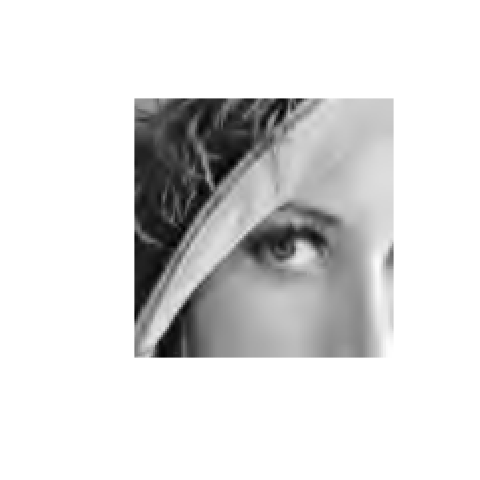

In [14]:
imageplot(clamp(SoftThreshPsi(f0, 0.1)))

Inpainting using Orthogonal Wavelet Sparsity
--------------------------------------------
If $\Psi$ is an orthogonal basis, a change of variable shows that the
synthesis prior is also an analysis prior, that reads
$$f^{\star} \in \text{argmin}_f \: E(f) = \frac{1}{2}\|y-\Phi f\|^2 + \lambda \sum_m \|\langle f,\psi_m \rangle\|. $$


To solve this non-smooth optimization problem, one can use
forward-backward splitting, also known as iterative soft thresholding.


It computes a series of images $f^{(\ell)}$ defined as
$$ f^{(\ell+1)} = S_{\tau\lambda}^{\Psi}( f^{(\ell)} - \tau \Phi^{*} (\Phi f^{(\ell)} - y)  ) $$


Set up the value of the threshold.

In [15]:
lambd = .03

In our setting, we have $ \Phi^* = \Phi $ which is an operator of norm
1.


For $f^{(\ell)}$ to converge to a solution of the problem, the gradient
step size should be chosen as
$$\tau < \frac{2}{\|\Phi^* \Phi\|} = 2$$


In the following we use:
$$\tau = 1$$


Since we use $ \tau=1 $ and $ \Phi = \Phi^* = \text{diag}(1-\Omega) $,  the gradient descent step
is a projection on the inpainting constraint
$$ C = \{ f \backslash \forall \Omega(x)=0, f(x)=y(x) \} $$
One thus has
$$ f - \tau \Phi^{*} (\Phi f - y)  = \text{Proj}_C(f) $$


For the sake of simplicity, we define a shortcut for this projection
operator.

In [16]:
ProjC = function(f, Omega){Omega * f + (1 - Omega) * y}

Each iteration of the forward-backward (iterative thresholding) algorithm
thus reads:
$$ f^{(\ell+1)} = S_{\lambda}^\Psi( \text{Proj}_C(f^{(\ell)}) ). $$


Initialize the iterations.

In [17]:
fSpars = y

First step: gradient descent.

In [18]:
fSpars = ProjC(fSpars, Omega)

Second step: denoise the solution by thresholding.

In [19]:
fSpars = SoftThreshPsi(fSpars, lambd)

__Exercise 1__

Perform the iterative soft thresholding.
Monitor the decay of the energy $E$ you are minimizing.

In [20]:
# Insert your code here.

Display the result.

In [21]:
# Insert your code here.

__Exercise 2__

Since there is no noise, one should in theory take $\lambda
\rightarrow 0$.
To do this, decay the value of $\lambda$ through the iterations.

In [22]:
# Insert your code here.

Inpainting using Translation Invariant Wavelet Sparsity
-------------------------------------------------------
Orthogonal sparsity performs a poor regularization because of the lack of
translation invariance. This regularization is enhanced by considering
$\Psi$ as a redundant tight frame of translation invariant wavelets.


One thus looks for optimal coefficients $a^\star$ that solves
$$a^{\star} \in \text{argmin}_a \: E(a) = \frac{1}{2}\|y-\Phi \Psi a\|^2 + \lambda J(a)$$


*Important*: The operator $\Psi^*$ is the forward translation invariant wavelet transform.
It computes the inner product with the unit norm wavelet atoms:
$$ (\Psi^* f)_m = \langle f,\psi_m \rangle \quad \text{with} \quad \|\psi_m\|=1. $$


The reconstruction operator $\Xi$ satisfies $ \Xi \Psi^* f = f $, and
is the pseudo inverse of the analysis operator $ \Xi = (\Psi^*)^+ $.


For our algorithm, we will need to use $\Psi$ and not $\Xi$. Lukily,
for the wavelet transform, one has
$$ \Xi = \Psi \text{diag(U)} f $$
where $U_m$ account for the redundancy of the scale of the atom
$\psi_m$.


Compute the scaling factor (inverse of the redundancy).

In [23]:
J = Jmax - Jmin + 1
u = c(4**(-J), 4**(floor(-1 * seq(J + 2./3,1,by=-1 /3.) + 1)))
U = array(0, dim=c(n, n, length(u)))
for (i in 1:length(u))
{
    U[,,i] = u[i]
}
U = aperm(U, c(3, 1, 2))

Choose a value of the regularization parameter.

In [24]:
lambd = .01

Shortcut for the wavelet transform and the reconstruction.

In [25]:
Xi = function(a){perform_wavelet_transf(a, Jmin, -1, ti=1)}
PsiS = function(f){perform_wavelet_transf(f, Jmin, + 1, ti=1)}
Psi = function(a){Xi(a/U)}

The forward-backward algorithm now compute a series of wavelet
coefficients $a^{(\ell)}$ computed as
$$a^{(\ell+1)} = S_{\tau\lambda}( a^{(\ell)} + \Psi^*\Phi( y - \Phi\Psi a^{(\ell)} )  ). $$


The soft thresholding is defined as:
$$\forall m, \quad S_T(a)_m = \max(0, 1-T/\|a_m\|)a_m. $$


The step size should satisfy:
$$\tau < \frac{2}{\|\Psi\Phi \|} \leq 2 \min( u ). $$

In [26]:
tau = 1.9 * min(u)

Initialize the wavelet coefficients with those of the previous reconstruction.

In [27]:
a = U * PsiS(fSpars)

Gradient descent.

In [28]:
fTI = Psi(a)
a = a + tau * PsiS(Phi(y - Phi(fTI, Omega), Omega))

Soft threshold.

In [29]:
a = SoftThresh(a, lambd * tau)

__Exercise 3__

Perform the iterative soft thresholding. Monitor the decay of the
energy $E$.

In [30]:
## Insert your code here.

Perform the reconstruction.

In [31]:
## Insert your code here.

Display the result.

In [32]:
## Insert your code here.

__Exercise 4__

Perform the iteration with a decaying value of $\lambda$

In [33]:
## Insert your code here.

Inpainting using Iterative Hard Thresholding
--------------------------------------------
To improve the sparsity of the solution, it is possible to replace the
soft thresholding by a hard threshdoling. In this case, the resulting
algorihtm does not perform anymore a variational minimization of an
energy.


The hard thresholding is defined as $h_T(x)=0$ if $-T < x < T$
and $h_T(x)=x$ otherwise. It thus defines a thresholding operator of
wavelet coefficients as $H_T(a)_m = h_T(a_m)$.


Define a shortcut for this vectorialized hard thresholding



*Important:* Scilab users have to create a file |HardThresh.m| to implement this
function.

In [34]:
HardThresh = function(x, t){x * (abs(x) > t)}

Display a curve of the 1-D Hard thresholding.

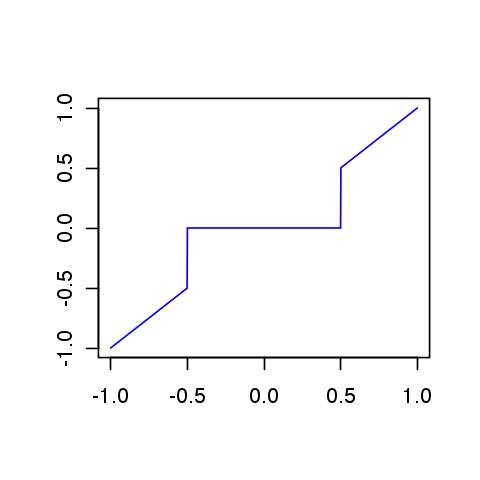

In [35]:
x = seq(-1, 1, length=1000)

plot(x, HardThresh(x, .5), col=4, type="l", xlab="", ylab="")

The hard thresholding in the translation invariant wavelet basis $\Psi$
reads
$$ H_T^\Psi(f) = \Xi \circ H_T \circ \Psi^* (f) $$
where $\Xi = (\Phi^*)^+$ is the reconstruction operator.


We follow the MCA paradigm of Jean-Luc Starck, that alternates between a
gradient descent step and a hard thresholding denoising, using a decaying
threshold.
$$f^{(\ell+1)} = H_{\tau\lambda_\ell}^\Psi( f^{(\ell)} - \tau \Phi^*(\Phi f^{(\ell)} - y)  ). $$


Number of iterations.

In [36]:
niter = 500

List of thresholds. One must start by a large enough initial threshold.

In [37]:
lambda_list = seq(1, 0, length=niter)

Initialization.

In [38]:
fHard = y

Gradient descent.

In [39]:
fHard = ProjC(fHard, Omega)

Hard threshold (here $\lambda=\lambda_0$) is used).

In [40]:
fHard = Xi(HardThresh(PsiS(fHard), tau * lambda_list[1]))

__Exercise 5__

Perform the iteration with a decaying value of $\lambda$

In [41]:
## Insert your code here.